<a href="https://colab.research.google.com/github/marcochisci/Anomaly_detection/blob/main/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Apache Spark 3.0.0

In [ ]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark3.0.0
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
# unzip it
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
# install findspark 
!pip install -q findspark

# Set Environment Variables

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

#Create local spark session


In [ ]:
import findspark
findspark.init()
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

Installation Test and pyspark version

In [ ]:
#create a test schema
from pyspark.sql.types import *
from pyspark.sql import Row

schema = StructType([StructField('name', StringType()), StructField('age',IntegerType())])
rows = [Row(name='Severin', age=33), Row(name='John', age=48)]
df = spark.createDataFrame(rows, schema)

df.printSchema()
df.show()


# Check the pyspark version
import pyspark
print(pyspark.__version__)


root
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)

+-------+---+
|   name|age|
+-------+---+
|Severin| 33|
|   John| 48|
+-------+---+

3.0.0


# Airquino Table Data

In [1]:
import pandas as pd
import psycopg2
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates


conn = psycopg2.connect(host='playground.magentalab.it', port='55432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query = """select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-06-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float);""".format(29510692, 23284701)  #23284701 is a specific station

df = pd.read_sql(query, conn)
df= df.set_index('Dates')

#removing nans
df = df.dropna()

display(df.head(10))

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-06-29 10:40:00,466.0,2.0,414.0,3896.0,276.0,9.0,512.0,301.0,226.0,358.0
2021-06-29 10:42:00,470.0,2.0,413.0,3983.0,279.0,11.0,513.0,335.0,227.0,366.0
2021-06-29 10:46:00,480.0,2.0,414.0,4147.0,286.0,10.0,487.0,291.0,226.0,365.0
2021-06-29 10:48:00,476.0,2.0,413.0,4179.0,287.0,8.0,477.0,282.0,224.0,365.0
2021-06-29 11:00:00,458.0,1.0,410.0,4291.0,292.0,7.0,419.0,240.0,216.0,367.0
2021-06-29 11:03:00,453.0,1.0,410.0,4301.0,292.0,4.0,394.0,229.0,212.0,367.0
2021-06-29 11:06:00,447.0,1.0,410.0,4315.0,293.0,5.0,393.0,245.0,211.0,371.0
2021-06-29 11:07:00,450.0,1.0,409.0,4323.0,295.0,5.0,395.0,253.0,216.0,377.0
2021-06-29 11:09:00,454.0,1.0,409.0,4337.0,296.0,6.0,400.0,253.0,217.0,379.0


Plots

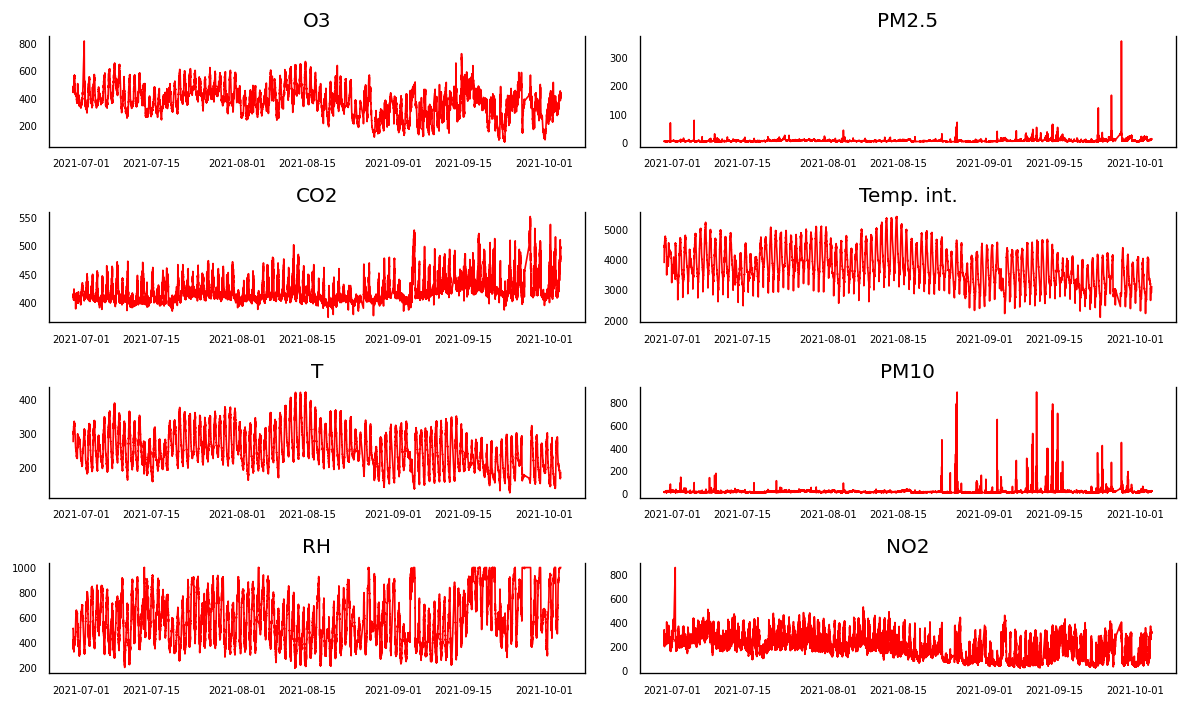

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Testing for Correlation
Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.




In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,O3_x,PM2.5_x,CO2_x,Temp. int._x,T_x,PM10_x,RH_x,NO2_x,CO_x,VOC_x
O3_y,1.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
PM2.5_y,0.0,1.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
CO2_y,0.0,0.0,1.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
Temp. int._y,0.0,0.0,0.0,1.0000,0.0000,0.2382,0.0,0.0,0.0,0.0
T_y,0.0,0.0,0.0,0.0000,1.0000,0.0031,0.0,0.0,0.0,0.0
PM10_y,0.0,0.0,0.0,0.0074,0.0045,1.0000,0.0,0.0,0.0,0.0
RH_y,0.0,0.0,0.0,0.0000,0.0000,0.0133,1.0,0.0,0.0,0.0
NO2_y,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,1.0,0.0,0.0
CO_y,0.0,0.0,0.0,0.0000,0.0000,0.2258,0.0,0.0,1.0,0.0
VOC_y,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,1.0


If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

# Testing for Cointegration
When two or more time series are cointegrated, it means they have a statistically significant relationship.


In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
O3     ::  9071.76   > 219.4051  =>   True
PM2.5  ::  5401.81   > 179.5199  =>   True
CO2    ::  2963.8    > 143.6691  =>   True
Temp. int. ::  1511.32   > 111.7797  =>   True
T      ::  934.26    > 83.9383   =>   True
PM10   ::  569.28    > 60.0627   =>   True
RH     ::  301.55    > 40.1749   =>   True
NO2    ::  111.88    > 24.2761   =>   True
CO     ::  45.52     > 12.3212   =>   True
VOC    ::  0.04      > 4.1296    =>   False


# Testing stationarity 

Test first 3 colums: O3, PM2.5, CO2

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results1 = {
    col: test_stationarity(df, col)
    for col in df[df.columns[0:3]].columns
}
adf_test_results1    

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'CO2': 'Stationary', 'O3': 'Stationary', 'PM2.5': 'Stationary'}

Test T, Temp. int. and PM10

In [ ]:
adf_test_results2 = {
    col: test_stationarity(df, col)
    for col in df[df.columns[3:6]].columns
}
adf_test_results2   

{'PM10': 'Stationary', 'T': 'Stationary', 'Temp. int.': 'Stationary'}

Test RH, NO2, CO and VOC

In [ ]:
adf_test_results3 = {
    col: test_stationarity(df, col)
    for col in df[df.columns[6:10]].columns
}
adf_test_results3   

{'CO': 'Stationary',
 'NO2': 'Stationary',
 'RH': 'Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df[col] = differencing(df, col, 1)

Test for stationarity now

# VAR model

Finding the best lag for VAR model

In [3]:
from statsmodels.tsa.api import VAR
max_lag = 40
var_model = VAR(df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


40


Finding anomalies

In [4]:
import numpy as np

#0 means that is it not an anomaly
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold
var = VAR(df)
var_fitresults = var.fit(selected_lag)
squared_errors = var_fitresults.resid.sum(axis=1) ** 2
predictions, threshold = find_anomalies(squared_errors)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [5]:
data = df.iloc[selected_lag:, :]
data['Predictions'] = predictions.values
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-06-29 12:46:00,465.0,1.0,407.0,4507.0,314.0,5.0,369.0,216.0,217.0,385.0,0
2021-06-29 12:48:00,468.0,1.0,407.0,4517.0,315.0,9.0,370.0,219.0,218.0,386.0,0
2021-06-29 12:51:00,473.0,1.0,408.0,4534.0,317.0,5.0,362.0,228.0,218.0,389.0,0
2021-06-29 12:54:00,473.0,1.0,408.0,4539.0,316.0,5.0,370.0,214.0,217.0,386.0,0
2021-06-29 12:55:00,475.0,1.0,408.0,4546.0,315.0,6.0,370.0,225.0,218.0,388.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-04 08:40:00,427.0,9.0,497.0,3054.0,182.0,16.0,999.0,319.0,245.0,372.0,0
2021-10-04 08:41:00,430.0,9.0,497.0,3066.0,183.0,15.0,999.0,318.0,245.0,371.0,0
2021-10-04 08:43:00,428.0,9.0,496.0,3074.0,184.0,14.0,999.0,316.0,245.0,369.0,0


In [6]:
data['Predictions'].value_counts()

0    85246
1      569
Name: Predictions, dtype: int64

Forecasting the values using the var model

In [7]:
forecast = var_fitresults.forecast(var_fitresults.y, steps=len(df)-selected_lag)
print(forecast)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


[[436.20795032   9.28424811 494.02462081 ... 317.62681204 244.7795264
  373.72964841]
 [437.34151521   9.48529285 493.32173208 ... 316.5306534  244.5930163
  373.46116522]
 [438.37220903   9.72005456 492.78773746 ... 315.12962376 244.55258744
  373.02129841]
 ...
 [370.53665683   3.67665411 420.06201389 ... 191.41796827 229.42715369
  340.58648407]
 [370.53665683   3.67665411 420.06201389 ... 191.41796827 229.42715369
  340.58648407]
 [370.53665683   3.67665411 420.06201389 ... 191.41796827 229.42715369
  340.58648407]]


Converting the forecasted values into a dataframe

In [8]:
from numpy import sqrt 
from sklearn.metrics import mean_squared_error

#converting predictions to dataframe
cols = df.columns
pred = pd.DataFrame(index=range(0,len(forecast)),columns=[cols])
for j in range(0,10):
    for i in range(0, len(forecast)):
       pred.iloc[i][j] = forecast[i][j]


In [9]:
display(pred)

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
0,436.208,9.28425,494.025,3086.74,185.458,15.9586,995.772,317.627,244.78,373.73
1,437.342,9.48529,493.322,3087.68,185.779,15.9097,994.029,316.531,244.593,373.461
2,438.372,9.72005,492.788,3090.23,186.163,16.6239,992.297,315.13,244.553,373.021
3,439.309,9.95532,492.211,3093.61,186.566,18.1358,990.461,314.284,244.49,373.425
4,440.183,10.2049,491.751,3098.36,187.092,19.2819,988.885,314.503,244.411,373.646
...,...,...,...,...,...,...,...,...,...,...
85810,370.537,3.67665,420.062,3760.95,250.231,9.272,592.022,191.418,229.427,340.586
85811,370.537,3.67665,420.062,3760.95,250.231,9.272,592.022,191.418,229.427,340.586
85812,370.537,3.67665,420.062,3760.95,250.231,9.272,592.022,191.418,229.427,340.586
85813,370.537,3.67665,420.062,3760.95,250.231,9.272,592.022,191.418,229.427,340.586


Creating a data frame with all the informations:
on the left side there are the actual values and on the right side there are the predicted values;
0 means it is not an anomaly and 1 means it is

In [10]:
data.reset_index(drop=True, inplace=True)
results=pd.concat([data, pred], axis=1)
results['Dates'] = df.index[selected_lag:]
results=results.set_index('Dates')
results

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,"(O3,)","(PM2.5,)","(CO2,)","(Temp. int.,)","(T,)","(PM10,)","(RH,)","(NO2,)","(CO,)","(VOC,)"
Dates,,,,,,,,,,,,,,,,,,,,,
2021-06-29 12:46:00,465.0,1.0,407.0,4507.0,314.0,5.0,369.0,216.0,217.0,385.0,0,436.208,9.28425,494.025,3086.74,185.458,15.9586,995.772,317.627,244.78,373.73
2021-06-29 12:48:00,468.0,1.0,407.0,4517.0,315.0,9.0,370.0,219.0,218.0,386.0,0,437.342,9.48529,493.322,3087.68,185.779,15.9097,994.029,316.531,244.593,373.461
2021-06-29 12:51:00,473.0,1.0,408.0,4534.0,317.0,5.0,362.0,228.0,218.0,389.0,0,438.372,9.72005,492.788,3090.23,186.163,16.6239,992.297,315.13,244.553,373.021
2021-06-29 12:54:00,473.0,1.0,408.0,4539.0,316.0,5.0,370.0,214.0,217.0,386.0,0,439.309,9.95532,492.211,3093.61,186.566,18.1358,990.461,314.284,244.49,373.425
2021-06-29 12:55:00,475.0,1.0,408.0,4546.0,315.0,6.0,370.0,225.0,218.0,388.0,0,440.183,10.2049,491.751,3098.36,187.092,19.2819,988.885,314.503,244.411,373.646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-04 08:40:00,427.0,9.0,497.0,3054.0,182.0,16.0,999.0,319.0,245.0,372.0,0,370.537,3.67665,420.062,3760.95,250.231,9.272,592.022,191.418,229.427,340.586
2021-10-04 08:41:00,430.0,9.0,497.0,3066.0,183.0,15.0,999.0,318.0,245.0,371.0,0,370.537,3.67665,420.062,3760.95,250.231,9.272,592.022,191.418,229.427,340.586
2021-10-04 08:43:00,428.0,9.0,496.0,3074.0,184.0,14.0,999.0,316.0,245.0,369.0,0,370.537,3.67665,420.062,3760.95,250.231,9.272,592.022,191.418,229.427,340.586


This are the detected anomalies

In [11]:
anomalies = results[(results['Predictions'] == 1)]
anomalies

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,"(O3,)","(PM2.5,)","(CO2,)","(Temp. int.,)","(T,)","(PM10,)","(RH,)","(NO2,)","(CO,)","(VOC,)"
Dates,,,,,,,,,,,,,,,,,,,,,
2021-06-29 22:41:00,433.0,2.0,388.0,3478.0,257.0,4.0,573.0,401.0,237.0,336.0,1,417.667,7.39987,441.454,3731.77,253.984,15.3355,677.533,183.433,235.578,361.172
2021-06-30 16:18:00,360.0,67.0,407.0,4249.0,283.0,77.0,307.0,274.0,202.0,407.0,1,365.288,5.08652,426.925,3667.99,245.841,11.1045,633.479,164.381,232.662,339.441
2021-06-30 16:19:00,368.0,19.0,407.0,4254.0,284.0,26.0,304.0,229.0,197.0,376.0,1,365.266,5.08501,426.919,3667.95,245.832,11.1025,633.457,164.401,232.656,339.431
2021-06-30 22:41:00,353.0,3.0,395.0,3224.0,232.0,13.0,581.0,329.0,226.0,311.0,1,362.544,4.80074,425.787,3667.23,244.827,10.7306,627.629,168.817,231.534,338.125
2021-07-01 15:32:00,763.0,1.0,407.0,3634.0,312.0,5.0,333.0,777.0,205.0,326.0,1,362.229,4.42996,424.126,3685.53,245.387,10.2562,615.774,175.159,230.181,337.883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-02 21:45:00,510.0,19.0,455.0,3024.0,180.0,26.0,915.0,306.0,250.0,424.0,1,370.537,3.67665,420.062,3760.95,250.231,9.272,592.022,191.418,229.427,340.586
2021-10-03 03:39:00,398.0,17.0,465.0,2205.0,149.0,23.0,999.0,352.0,217.0,319.0,1,370.537,3.67665,420.062,3760.95,250.231,9.272,592.022,191.418,229.427,340.586
2021-10-03 03:42:00,401.0,17.0,482.0,2437.0,149.0,21.0,999.0,311.0,217.0,326.0,1,370.537,3.67665,420.062,3760.95,250.231,9.272,592.022,191.418,229.427,340.586


Comparing the actual values and the predicted values

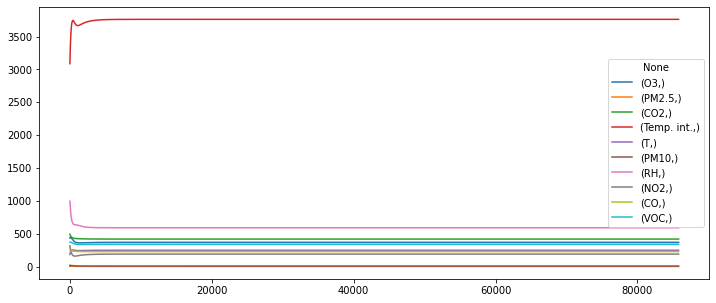

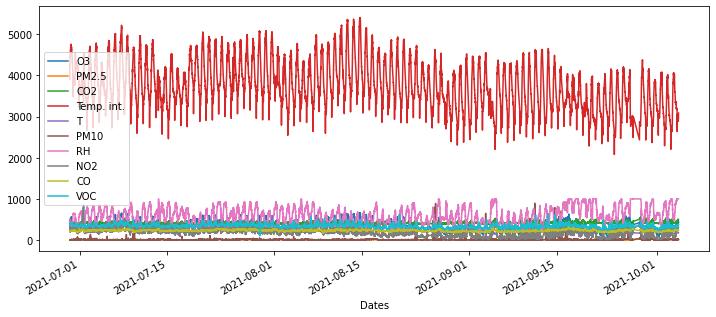

In [12]:
pred.plot(figsize=(12,5),legend=True)
df.plot(figsize=(12,5),legend=True)